# 1. Illustration of Markov’s, Chebyshev’s, and Hoeffding’s Inequalities (24 points)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb


class BernoulliExperiment:
    def __init__(self, start, stop, step, bias, exact_probability_for_alpha_value, plot_filename=None):
        # Filename of the plot to be saved (if None, no plot is saved)
        self.plot_filename = plot_filename

        # Alpha values to be tested
        self.start = start
        self.stop = stop
        self.step = step
        self.bias = bias
        self.alphas = np.arange(self.start, self.stop + self.step, self.step)

        # Empirical frequency and bounds for each alpha value
        self.empirical_frequencies = []
        self.markov_bounds = []
        self.chebyshev_bounds = []
        self.hoeffding_bounds = []

        # Calculate exact probabilities for the following alpha values
        self.exact_probability_for_alpha_value = exact_probability_for_alpha_value

        # Number of i.i.d. Bernoulli random variables being drawn in each repetition of the experiment
        self.n = 20

        # Number of repetitions the entire experiment (i.e. number of drawing self.n Bernoulli random variables) is repeated.
        self.num_repetitions = 1000000

        # Title for the experiment
        self.title = "Bernoulli Experiment"
        self.subtitle = (
            f"α ∈ {{{self.start:.2f}, {self.start + self.step:.2f}, ...,"
            f" {self.stop:.2f}}}, bias={self.bias:.2f}"
        )

    def run_experiment(self):
        for alpha in self.alphas:
            # Simulate Bernoulli trials
            # generate a matrix of size (num_repetitions, n) where each element is either 0 or 1
            # each row represents the result of a single experiment
            # each column represents the result of a single trial
            experiment_results = np.random.binomial(1, self.bias, size=(self.num_repetitions, self.n))

            # Mean of each experiment
            # X = [X[0], X[1], ..., X[num_repetitions - 1]]
            # X[i] = mean of the i-th experiment
            X = np.mean(experiment_results, axis=1)  # axis=1 -> mean of each row

            # Expectation of random variable
            # E[X] = 1/n * sum(X[i])
            EX = np.mean(X)

            # k = |α - E[X]|
            k = np.abs(alpha - EX)

            # Empirical frequency
            count = np.sum(X >= alpha)
            empirical_frequency = count / self.num_repetitions
            self.empirical_frequencies.append(empirical_frequency)

            # Markov's bound: P(X >= α) <= E[X] / α
            markov_bound = EX / alpha
            self.markov_bounds.append(min(markov_bound, 1))

            # Chebyshev's bound: P(|X - E[X]| >= k) <= Var(X) / k^2
            # k = |alpha - E[X]|
            var_X = np.var(X)
            chebyshev_bound = var_X / k**2
            self.chebyshev_bounds.append(min(chebyshev_bound, 1))

            # Hoeffding's bound: P(X - E[X] >= k) <= 2 * exp(-2 * k^2 * n)
            # Using corollabry 2.5, equation (2.4)
            hoeffding_bound = np.exp(-2 * self.n * k**2)
            self.hoeffding_bounds.append(hoeffding_bound)

    def exact_probability(self, alpha):
        # P(X >= α) = sum(comb(n, k) * p^k * (1 - p)^(n - k))
        return sum(
            comb(self.n, k) * self.bias**k * (1 - self.bias) ** (self.n - k)
            for k in range(int(self.n * alpha), self.n + 1)
        )

    def report(self):
        print("-" * 50)
        print(self.title)
        print(self.subtitle)
        for alpha in self.exact_probability_for_alpha_value:
            print(f"P(X >= {alpha:.2f}) ≈ {self.exact_probability(alpha):.2e}")
        print("-" * 50)

    def plot(self):
        # Size of the plot
        plt.figure(figsize=(10, 6))

        # Plot empirical frequency and bounds
        plt.plot(
            self.alphas, self.empirical_frequencies, marker="o", linestyle="-", label="Empirical frequency"
        )
        plt.plot(self.alphas, self.markov_bounds, marker="x", linestyle="--", label="Markov's bound")
        plt.plot(self.alphas, self.chebyshev_bounds, marker="s", linestyle="-.", label="Chebyshev's bound")
        plt.plot(self.alphas, self.hoeffding_bounds, marker="^", linestyle=":", label="Hoeffding's bound")

        # Plot settings
        plt.xlabel("α", fontsize=12)
        plt.xticks(self.alphas)
        plt.ylabel("Frequency (prob.)", fontsize=12)
        plt.suptitle(self.title, fontsize=14, x=0.53)
        plt.title(self.subtitle, fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        if self.plot_filename:
            plt.savefig(self.plot_filename)
        
        plt.show()

--------------------------------------------------
Bernoulli Experiment
α ∈ {0.50, 0.55, ..., 1.00}, bias=0.50
P(X >= 1.00) ≈ 9.54e-07
P(X >= 0.95) ≈ 2.00e-05
--------------------------------------------------


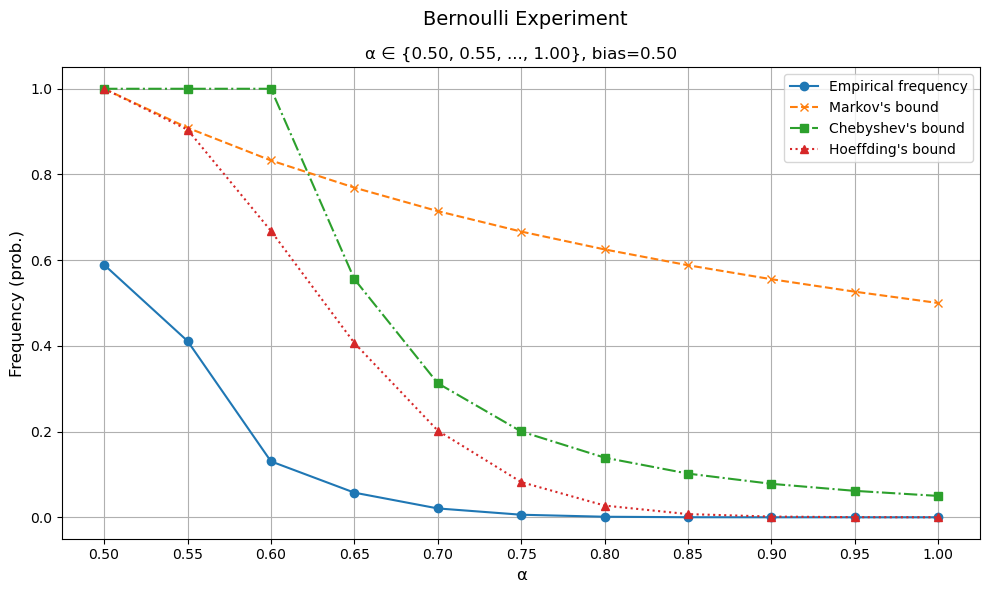

--------------------------------------------------
Bernoulli Experiment
α ∈ {0.10, 0.15, ..., 1.00}, bias=0.10
P(X >= 1.00) ≈ 1.00e-20
P(X >= 0.95) ≈ 1.81e-18
--------------------------------------------------


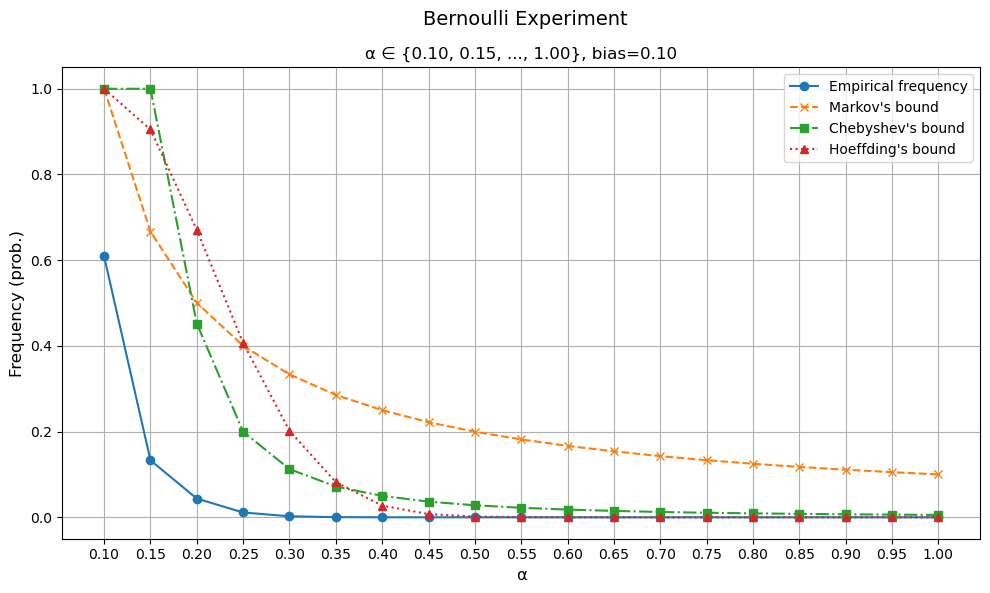

In [8]:
# Bernoulli experiment: bias = 0.5
experiment1 = BernoulliExperiment(
    start=0.5,
    stop=1,
    step=0.05,
    bias=0.5,
    exact_probability_for_alpha_value=[1, 0.95],
    plot_filename="images/bernoulli/bias_0.5.png",
)
experiment1.run_experiment()
experiment1.report()
experiment1.plot()

# Bernoulli experiment: bias = 0.1
experiment2 = BernoulliExperiment(
    start=0.1,
    stop=1,
    step=0.05,
    bias=0.1,
    exact_probability_for_alpha_value=[1, 0.95],
    plot_filename="images/bernoulli/bias_0.1.png",
)
experiment2.run_experiment()
experiment2.report()
experiment2.plot()

# 5. Linear Regression (50 points)

In [9]:
import numpy as np
import matplotlib.pyplot as plt


class LinearRegression:
    def __init__(self, data, X_map_func=None, plot_filename=None):
        # Function to map X values to X' values (i.e. X' = X_map_func(X))
        self.X_map_func = X_map_func

        # Filename of the plot to be saved (if None, no plot is saved)
        self.plot_filename = plot_filename

        # Parameters a and b to be determined
        self.a = None
        self.b = None

        # Predictions: h(x) = exp(a * x + b)
        self.y_pred = None

        # Sort dataset by X values
        sorted_indices = np.argsort(data[:, 0])
        self.X = data[:, 0][sorted_indices]
        self.y_true = data[:, 1][sorted_indices]

        # Construct dataset S'
        self.X_prime = X_map_func(self.X) if X_map_func else self.X
        self.y_prime = np.log(self.y_true)

        # Title for the model
        self.title = ("Non-Linear" if self.X_map_func else "Linear") + " Regression of Lake trouts"
        self.subtitle = "Age (years) vs. PCB concentration (ppm)\n" + (
            f"Transformation: x → {self.X_map_func.__name__}(x)" if self.X_map_func else ""
        )

    def fit_model(self):
        # Append a column of ones to X (equation 3.3 in [CI])
        X_tilde = np.c_[np.ones(self.X_prime.shape[0]), self.X_prime]

        # Calculate w* = (X^T * X)^-1 * X^T * y and obtain parameters a and b (equation 3.5 in [CI])
        w_star = np.linalg.inv(X_tilde.T.dot(X_tilde)).dot(X_tilde.T).dot(self.y_prime)
        # For one independent variable, w* contains only two parameters (b and a)
        self.b = w_star[0]
        self.a = w_star[1]

        # Fit model h'(x) = a * x + b
        h_prime = self.a * self.X_prime + self.b

        # Obtain final model h(x) = exp(h'(x)) (i.e. predictions)
        self.y_pred = np.exp(h_prime)

    def mse(self):
        # MSE = 1/n * sum((y - h(x))^2)
        return np.mean((self.y_true - self.y_pred) ** 2)

    def r2(self):
        # R^2 = 1 - sum((y - h(x))^2) / sum((y - y_bar)^2)
        y_bar = np.mean(self.y_true)

        return 1 - (np.sum((self.y_true - self.y_pred) ** 2) / np.sum((self.y_true - y_bar) ** 2))

    def report(self):
        print("-" * 50)
        print(self.title)
        print(self.subtitle)
        print(f"a: {self.a:.4f}")
        print(f"b: {self.b:.4f}")
        print(f"MSE: {self.mse():.4f}")
        print(f"R^2: {self.r2():.4f}")
        print("-" * 50)

    def plot(self):
        # Size of the plot
        plt.figure(figsize=(10, 6))

        # Plot the true values and the predictions
        # Always use "normal" X scale
        plt.scatter(self.X, self.y_true, marker="o", label="True values")
        plt.plot(self.X, self.y_pred, marker="x", linestyle="-", color="r", label="Predictions")

        # Plot settings
        plt.xlabel("Age (years)", fontsize=12)
        plt.xticks(np.arange(min(self.X), max(self.X) + 1, 1))
        plt.ylabel("PCB concentration (ppm)", fontsize=12)
        plt.yscale("log")
        plt.suptitle(self.title, fontsize=14, x=0.53)
        plt.title(self.subtitle, fontsize=12)
        plt.legend()
        plt.grid(True, which="both")
        plt.tight_layout()
        if self.plot_filename:
            plt.savefig(self.plot_filename)
        plt.show()

--------------------------------------------------
Linear Regression of Lake trouts
Age (years) vs. PCB concentration (ppm)

a: 0.2591
b: 0.0315
MSE: 34.8356
R^2: 0.3570
--------------------------------------------------


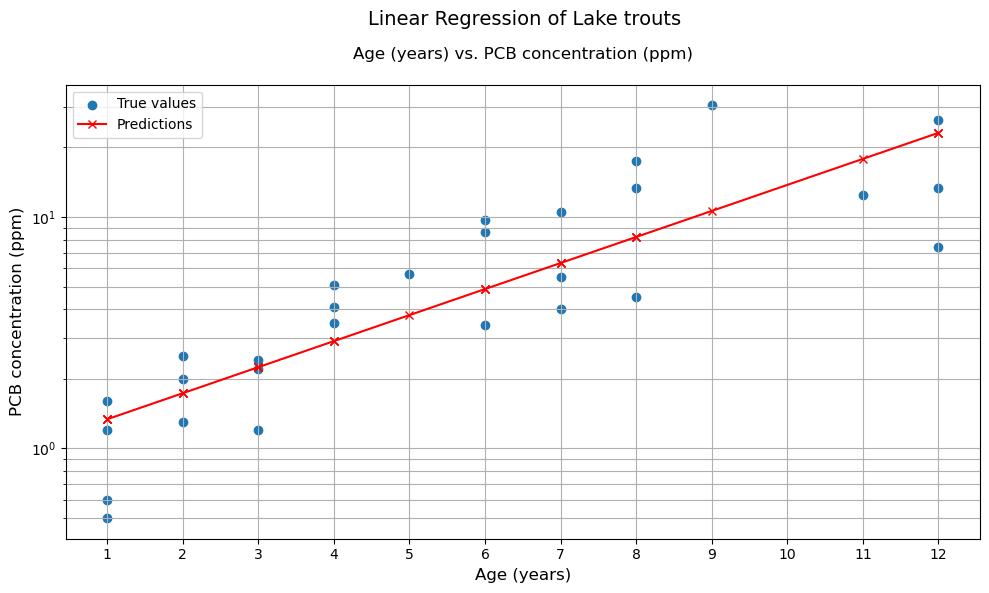

--------------------------------------------------
Non-Linear Regression of Lake trouts
Age (years) vs. PCB concentration (ppm)
Transformation: x → sqrt(x)
a: 1.1986
b: -1.1948
MSE: 28.0844
R^2: 0.4816
--------------------------------------------------


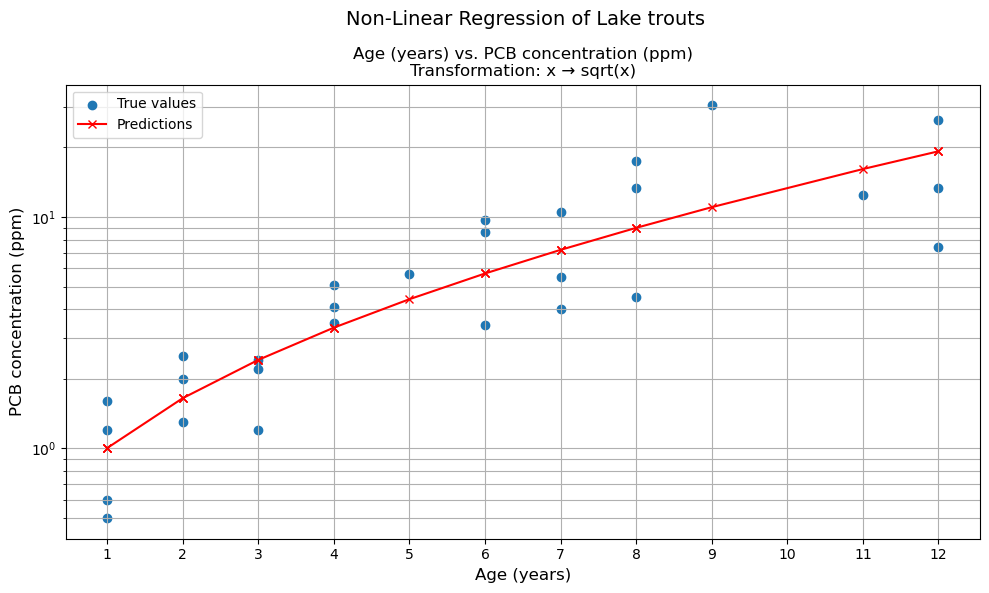

--------------------------------------------------
Non-Linear Regression of Lake trouts
Age (years) vs. PCB concentration (ppm)
Transformation: x → log(x)
a: 1.1874
b: -0.2576
MSE: 26.8417
R^2: 0.5046
--------------------------------------------------


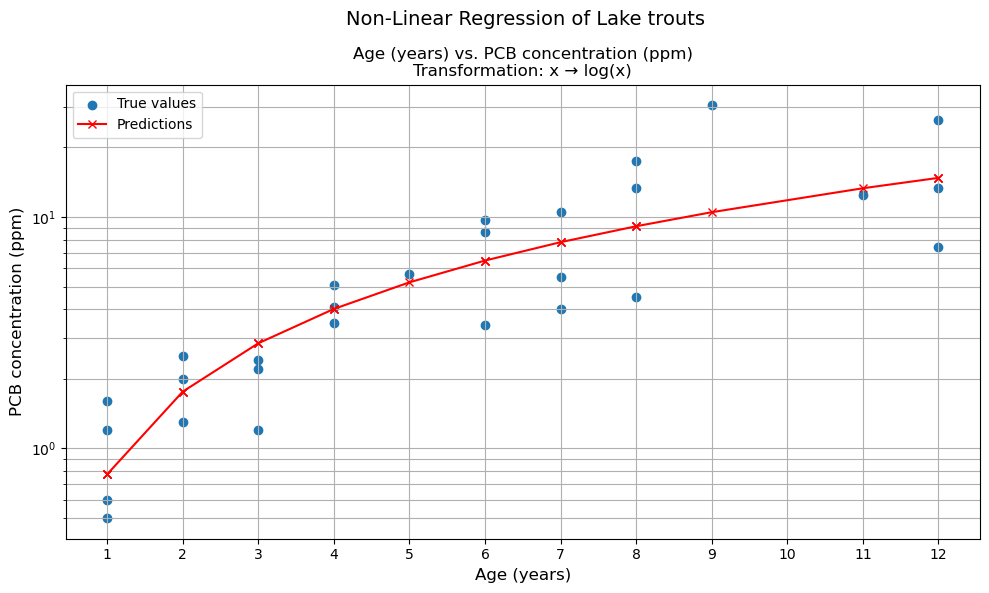

In [10]:
# Load the data from PCB.dt - each line contains a pair (x, y)
data = np.loadtxt("data/PCB.dt")

# Linear model
linear_model = LinearRegression(data, plot_filename="images/linear_regression/x_to_x.png")
linear_model.fit_model()
linear_model.report()
linear_model.plot()

# Non-linear model: x -> sqrt(x)
non_linear_model = LinearRegression(
    data, X_map_func=np.sqrt, plot_filename="images/linear_regression/x_to_sqrt_x.png"
)
non_linear_model.fit_model()
non_linear_model.report()
non_linear_model.plot()

# Non-linear model: x -> log(x)
non_linear_model2 = LinearRegression(
    data, X_map_func=np.log, plot_filename="images/linear_regression/x_to_log_x.png"
)
non_linear_model2.fit_model()
non_linear_model2.report()
non_linear_model2.plot()